✅ CSV 讀取成功：pokemon_newtype_zscore.csv (encoding=utf-8)

📌 正在進行 One-Hot Encoding 展示 (給老師看)...
原始標籤 y (前 5 筆):
[3 3 3 3 2]

轉換後的 One-Hot y (前 5 筆):
   Type_Group_1  Type_Group_2  Type_Group_3  Type_Group_4
0         False         False          True         False
1         False         False          True         False
2         False         False          True         False
3         False         False          True         False
4         False          True         False         False

⚠️ 注意：Scikit-learn 的 LogisticRegression 內部會自動處理 One-Hot，
   因此訓練時我們仍將使用原始的一維 y 標籤，以免報錯。

📌 類別分佈（原始資料）
Type_group
1    130
2    177
3    325
4    168
Name: count, dtype: int64

📌 類別分佈（Train）
Type_group
1    104
2    142
3    260
4    134
Name: count, dtype: int64

📌 類別分佈（Test）
Type_group
1    26
2    35
3    65
4    34
Name: count, dtype: int64

Classification Report (Train Set)
Accuracy: 0.4969
              precision    recall  f1-score   support

           1     0.4719    0.4038    0.4352       10

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



✅ 已輸出：confusion_matrix_count.png
✅ 已輸出：confusion_matrix_normalized.png


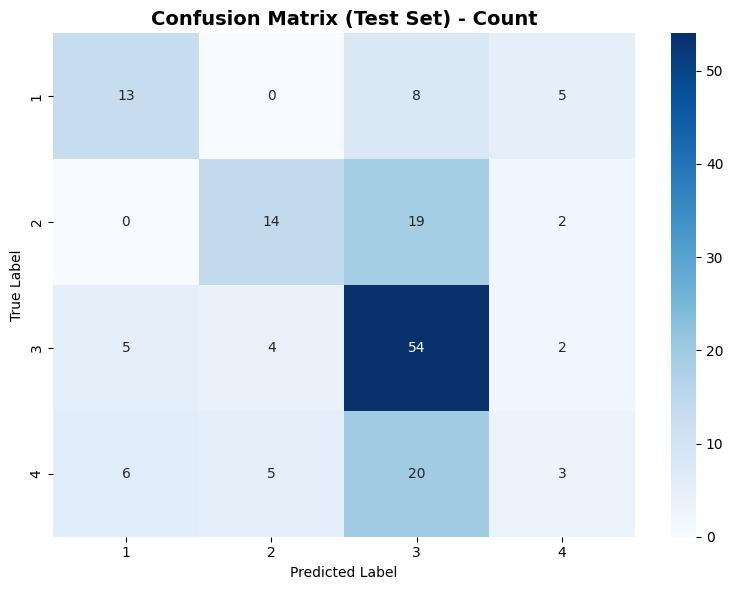

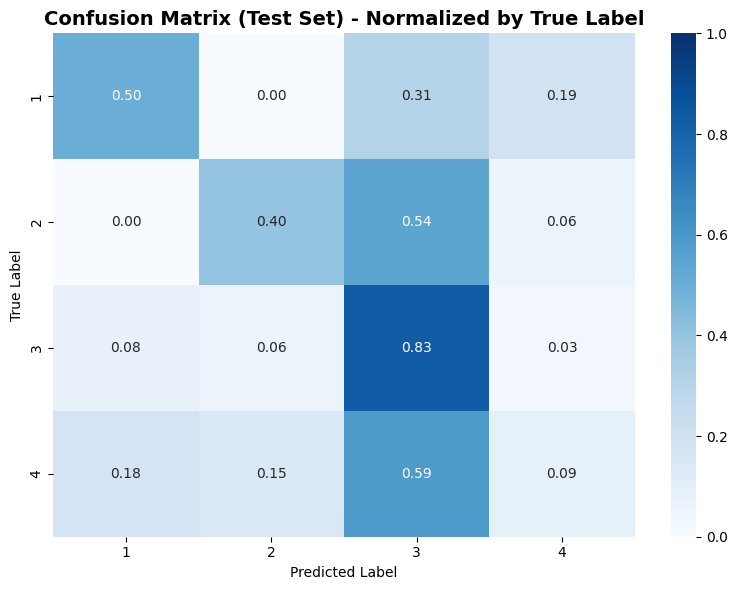

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline  # 改用標準 Pipeline

# ----------------------------------------------------
# 1. 資料載入
# ----------------------------------------------------
file_path = "pokemon_newtype_zscore.csv"

encodings = ["utf-8", "utf-8-sig", "cp950", "big5", "cp1252"]
df = None
used_encoding = None

for enc in encodings:
    try:
        df = pd.read_csv(file_path, encoding=enc)
        used_encoding = enc
        break
    except UnicodeDecodeError:
        continue

if df is None:
    raise RuntimeError("讀取 CSV 失敗：請確認檔案編碼或檔案是否損壞。")

print(f"✅ CSV 讀取成功：{file_path} (encoding={used_encoding})")

df.columns = df.columns.str.strip()

# ----------------------------------------------------
# 2. 指定特徵與標籤
# ----------------------------------------------------
feature_cols = ["HP", "Attack", "Defense", "Sp. Atk", "Sp. Def", "Speed"] #自變數(X)
target_col = "Type_group" #應變數(Y)

missing = [c for c in feature_cols + [target_col] if c not in df.columns]
if missing:
    print("❌ 你的 CSV 欄位如下：")
    print(df.columns.tolist())
    raise KeyError(f"缺少必要欄位：{missing}")

X = df[feature_cols].copy()
y = df[target_col].copy()

# 去掉缺值
data = pd.concat([X, y], axis=1).dropna()
X = data[feature_cols]
y = data[target_col]

# ==========================================
# 【新增】回應老師要求：展示 Y 的 One-Hot Encoding
# ==========================================
print("\n📌 正在進行 One-Hot Encoding 展示 (給老師看)...")
y_onehot = pd.get_dummies(y, prefix='Type_Group')

print("原始標籤 y (前 5 筆):")
print(y.head().values)

print("\n轉換後的 One-Hot y (前 5 筆):")
print(y_onehot.head())

print("\n⚠️ 注意：Scikit-learn 的 LogisticRegression 內部會自動處理 One-Hot，")
print("   因此訓練時我們仍將使用原始的一維 y 標籤，以免報錯。")
# ==========================================

print("\n📌 類別分佈（原始資料）")
print(y.value_counts().sort_index())
# ----------------------------------------------------
# 3. 切分 Train/Test（80/20）
# ----------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,      # 20% test
    random_state=42,
    stratify=y
)

print("\n📌 類別分佈（Train）")
print(pd.Series(y_train).value_counts().sort_index())
print("\n📌 類別分佈（Test）")
print(pd.Series(y_test).value_counts().sort_index())

# ----------------------------------------------------
# 4. Softmax 回歸 (無 SMOTE)
#    只保留標準化 (StandardScaler) 以幫助收斂，不做樣本調整
# ----------------------------------------------------
model = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("softmax", LogisticRegression(
        solver="lbfgs",
        multi_class="multinomial", # 明確指定為 Softmax (多類別)
        max_iter=5000,
        random_state=42
    ))
])

model.fit(X_train, y_train)

# ----------------------------------------------------
# 5. 產出 Train/Test 的報告
# ----------------------------------------------------
def evaluate(split_name, X_split, y_split):
    y_pred = model.predict(X_split)
    acc = accuracy_score(y_split, y_pred)
    print("\n" + "="*60)
    print(f"Classification Report ({split_name})")
    print("="*60)
    print(f"Accuracy: {acc:.4f}")
    print(classification_report(y_split, y_pred, digits=4, zero_division=0))
    return y_pred

y_pred_train = evaluate("Train Set", X_train, y_train)
y_pred_test  = evaluate("Test Set",  X_test,  y_test)

# ----------------------------------------------------
# 6. 混淆矩陣（Test Set）：Count + Normalized
# ----------------------------------------------------
classes = np.sort(y.unique())

cm = confusion_matrix(y_test, y_pred_test, labels=classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix (Test Set) - Count", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_count.png", dpi=300)
print("\n✅ 已輸出：confusion_matrix_count.png")

# normalized by true label（每一列加總=1）
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
cm_norm = np.nan_to_num(cm_norm)  # 避免某列全0造成 NaN

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=classes, yticklabels=classes,
            vmin=0, vmax=1)
plt.title("Confusion Matrix (Test Set) - Normalized by True Label", fontsize=14, fontweight="bold")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix_normalized.png", dpi=300)
print("✅ 已輸出：confusion_matrix_normalized.png")

In [4]:
# ----------------------------------------------------
# 7. 進階評估：5-Fold Cross-Validation (詳細每一折完整報告 + 最終統計)
# ----------------------------------------------------
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import accuracy_score # 確保有引入這行
import numpy as np

print("\n" + "="*80)
print("Running 5-Fold Cross-Validation (Detailed Classification Reports)")
print("="*80)

# 使用 StratifiedKFold 確保每一折的類別比例一致
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 確保資料格式為 numpy array 以便進行索引切分
X_train_np = X_train.values if hasattr(X_train, 'values') else X_train
y_train_np = y_train.values if hasattr(y_train, 'values') else y_train

# 【新增 1】建立一個空清單，用來存每一折的驗證準確率
val_accuracies = []

for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_train_np, y_train_np), 1):
    # 1. 切分訓練資料與驗證資料
    X_fold_train, X_fold_val = X_train_np[train_idx], X_train_np[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

    # 2. 訓練模型 (複製一個新的 best_model 來跑，避免影響原模型)
    model_clone = clone(model)
    model_clone.fit(X_fold_train, y_fold_train)

    # 3. 產生預測結果
    y_fold_train_pred = model_clone.predict(X_fold_train)
    y_fold_val_pred   = model_clone.predict(X_fold_val)

    # 【新增 2】計算該折的準確率並存起來
    acc = accuracy_score(y_fold_val, y_fold_val_pred)
    val_accuracies.append(acc)

    # 4. 印出該折的詳細報告
    print(f"\n{'#'*30} FOLD {fold_idx} (Acc: {acc:.4f}) {'#'*30}")

    print(f"\n--- Fold {fold_idx} Train Set Report ---")
    print(classification_report(y_fold_train, y_fold_train_pred, digits=4, zero_division=0))

    print(f"\n--- Fold {fold_idx} Validation Set Report ---")
    print(classification_report(y_fold_val, y_fold_val_pred, digits=4, zero_division=0))

# ----------------------------------------------------
# 【新增 3】迴圈結束後，計算平均值與標準差
# ----------------------------------------------------
mean_acc = np.mean(val_accuracies)
std_acc = np.std(val_accuracies)

print("\n" + "="*80)
print("5-Fold Cross-Validation Final Results")
print("="*80)
print(f"個別準確率 (Individual Accuracies): {val_accuracies}")
print(f"平均準確率 (Mean Accuracy):       {mean_acc:.4f}")
print(f"標準差 (Standard Deviation):      {std_acc:.4f}")
print("="*80)


Running 5-Fold Cross-Validation (Detailed Classification Reports)

############################## FOLD 1 (Acc: 0.5391) ##############################

--- Fold 1 Train Set Report ---
              precision    recall  f1-score   support

           1     0.5000    0.4286    0.4615        84
           2     0.4800    0.3186    0.3830       113
           3     0.5043    0.8365    0.6293       208
           4     0.3500    0.0654    0.1102       107

    accuracy                         0.4941       512
   macro avg     0.4586    0.4123    0.3960       512
weighted avg     0.4660    0.4941    0.4389       512


--- Fold 1 Validation Set Report ---
              precision    recall  f1-score   support

           1     0.5500    0.5500    0.5500        20
           2     0.5000    0.3793    0.4314        29
           3     0.5488    0.8654    0.6716        52
           4     0.5000    0.0741    0.1290        27

    accuracy                         0.5391       128
   macro avg     

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



############################## FOLD 2 (Acc: 0.5234) ##############################

--- Fold 2 Train Set Report ---
              precision    recall  f1-score   support

           1     0.4722    0.4096    0.4387        83
           2     0.4648    0.2920    0.3587       113
           3     0.5045    0.8173    0.6239       208
           4     0.3125    0.0926    0.1429       108

    accuracy                         0.4824       512
   macro avg     0.4385    0.4029    0.3910       512
weighted avg     0.4500    0.4824    0.4339       512


--- Fold 2 Validation Set Report ---
              precision    recall  f1-score   support

           1     0.5455    0.2857    0.3750        21
           2     0.5882    0.3448    0.4348        29
           3     0.5341    0.9038    0.6714        52
           4     0.3333    0.1538    0.2105        26

    accuracy                         0.5234       128
   macro avg     0.5003    0.4221    0.4229       128
weighted avg     0.5074    0.5

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



############################## FOLD 4 (Acc: 0.4297) ##############################

--- Fold 4 Train Set Report ---
              precision    recall  f1-score   support

           1     0.4932    0.4337    0.4615        83
           2     0.4933    0.3246    0.3915       114
           3     0.5321    0.8365    0.6505       208
           4     0.3514    0.1215    0.1806       107

    accuracy                         0.5078       512
   macro avg     0.4675    0.4291    0.4210       512
weighted avg     0.4794    0.5078    0.4640       512


--- Fold 4 Validation Set Report ---
              precision    recall  f1-score   support

           1     0.3889    0.3333    0.3590        21
           2     0.5455    0.2143    0.3077        28
           3     0.4457    0.7885    0.5694        52
           4     0.1429    0.0370    0.0588        27

    accuracy                         0.4297       128
   macro avg     0.3807    0.3433    0.3237       128
weighted avg     0.3943    0.4

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Calculating Precision-Recall & mAP
Mean Average Precision (mAP, micro-averaged): 0.5029

✅ 已輸出：multiclass_pr_curve.png


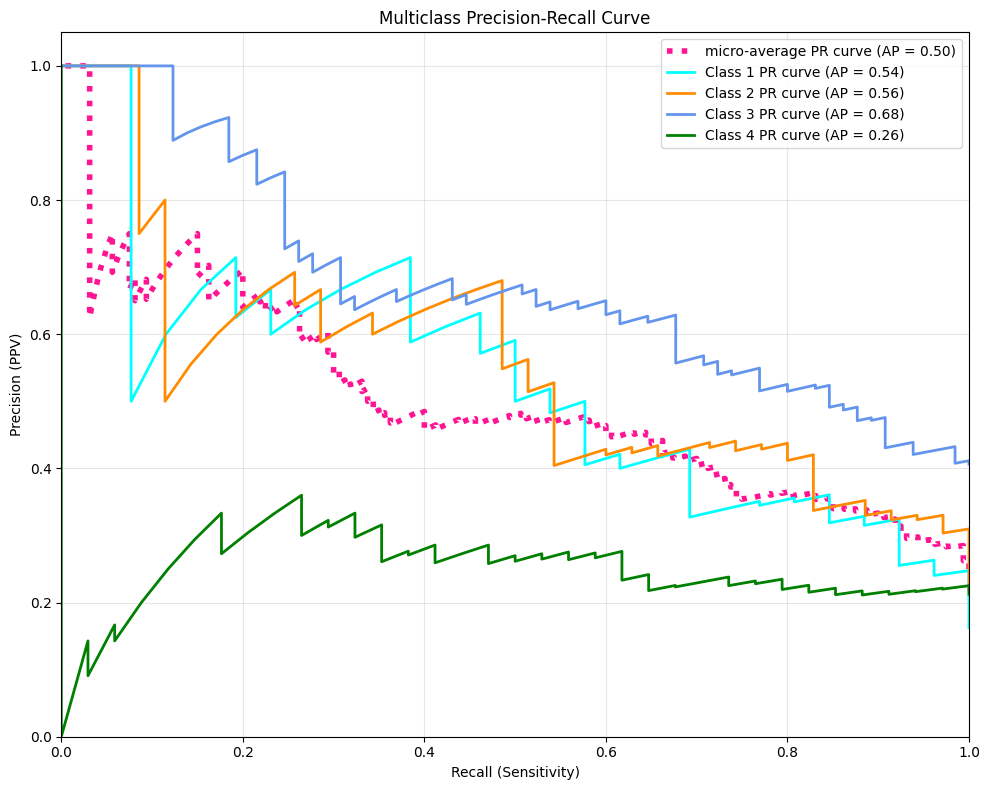


Generating Learning Curve...
✅ 已輸出：learning_curve.png


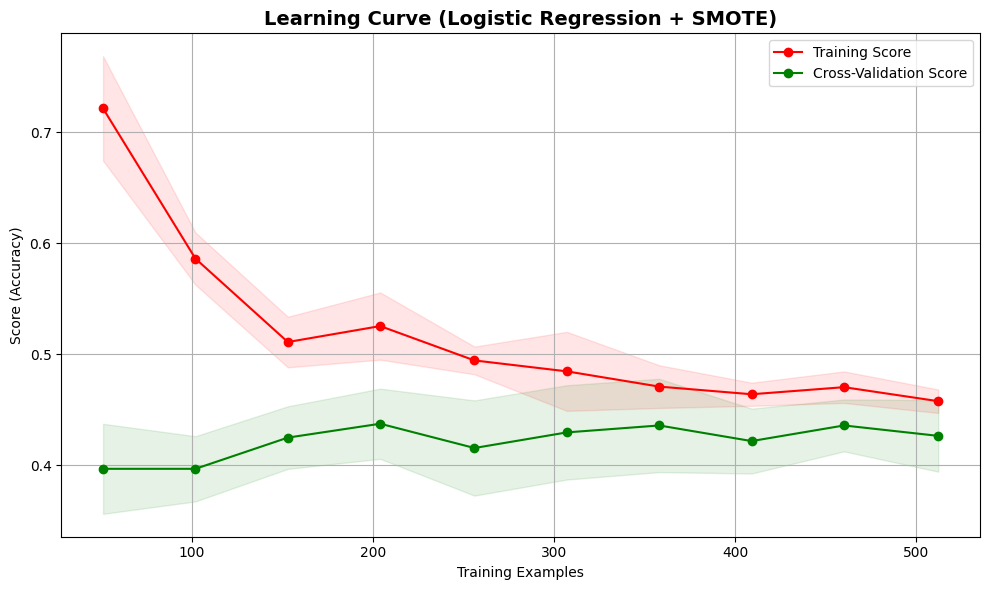